In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import os 
warnings.filterwarnings('ignore') 

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern, RBF
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

os.chdir("../../")

from src.algorithms import SubsetAlgorithm
from src.plotting import plot_algo_true_function
from src.models import MGPR
from scipy.io import loadmat
plt.style.use("mpl_style/matplotlib.rc")

## Writing an experimental goal as an algorithm

To begin, let's load data on a ternary phase diagram system of FeCoNi. Here, the X space (design space) consists of compositions c1, c2, c3; c3 = c1 + c2. Corresponding to each set of compositions are two magnetic property measurements: the Coercivity and the Kerr Rotation. Here X is the full discrete space and Y is the full measured property space. In a true sequential experiment, we would know which X to measure but Y would be unknown (i.e. the function of interest).

References: 

Yoo, Young-kook et al. “Identification of amorphous phases in the Fe–Ni–Co ternary alloy system using continuous phase diagram material chips.” Intermetallics 14 (2006): 241-247 (https://www.sciencedirect.com/science/article/pii/S096697950500186X).
Alex Wang, Haotong Liang, Austin McDannald, Ichiro Takeuchi, Aaron Gilad Kusne, Benchmarking active learning strategies for materials optimization and discovery, Oxford Open Materials Science, Volume 2, Issue 1, 2022, itac006, https://doi.org/10.1093/oxfmat/itac006 (https://academic.oup.com/ooms/article/2/1/itac006/6637521).


First download the data file "FeCoNi_benchmark_dataset_220501a.mat" from https://github.com/usnistgov/remi/tree/nist-pages/data/Combinatorial%20Libraries/Fe-Co-Ni and place it in the datasets directory. 

In [2]:
data = loadmat('datasets/FeCoNi_benchmark_dataset_220501a.mat')
X = data['C'][:,0:2] # only need 2 dimensions of composition since c3 = c2 + c1 
Y1 = data['Coer'] # magnetic property 1 
Y2 = data['Kerr'] # magnetic property 2 
Y = np.hstack((Y1, Y2))
n_features, n_properties = X.shape[1], Y.shape[1]

print("Size of the design space: {}, Size of the measured property space: {}".format(X.shape, Y.shape))

Size of the design space: (921, 2), Size of the measured property space: (921, 2)


To begin, we normalize X to between 0-1 for each of the compositions. We normalize Y to be between -1 and 1 for each of the properties. Note, here there is a question of how Y can be normalized when it is unknown (i.e. we shouldn't know the minimum or maximum values). In practice, the max and min values are obtained based on a user guess and can be approximate. 

In [3]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

X_unnorm, Y_unnorm = x_scaler.inverse_transform(X), y_scaler.inverse_transform(Y)


## Experimental goal <---> Algorithm

Let us consider the experimental goal of finding the set of materials (composition tuples) for which either the value for the Kerr Rotation is above the 90th percentile or the value for the Coercivity is above the 90th percentile. Note, there are 921 alloys in this dataset. This means that there will be between (0.1 * 921) and (2 * 0.1 * 921) alloys which statisfy this experimental goal. The former would correspond to the case where the top 10% w.r.t Kerr Rotation were the same alloys that achieved top 10% w.r.t Coercivity (i.e. intersection = 100%). The second case would be if the two conditions are disjoint.   

Now, let's turn to the task of writing this goal as an algorithm. Below we show the general structure of a SubsetAlgorithm. Each algorithm must implement a method named identify_subspace which takes in generic arguments x, y. The return from the algorithm are the set of ids corresponding to the x values which satisfy the goal. 

The algorithm below simply determines the which values of Y are bigger than the 90% threshold for each property. The union is taken to return the set that either beats the 90% percentile for property 1 or property 2. 

In [4]:
class PercentileIntersection2D(SubsetAlgorithm):
    def __init__(self, user_algo_params):
        super().__init__(user_algo_params)

    def user_algorithm(self, f_x, x):
        # percentile threshold value for property 1 
        percentile_list = self.user_algo_params['percentile_list']
        percentile_threshold_p1 = np.percentile(f_x[:, 0], percentile_list[0])

        # percentile threshold value for property 2    
        percentile_threshold_p2 = np.percentile(f_x[:, 1], percentile_list[1])

        # Determine the ids where each condition holds seperately 
        ids1 = set(np.where(f_x[:,0] >= percentile_threshold_p1)[0])
        ids2 = set(np.where(f_x[:,1] >= percentile_threshold_p2)[0])

        # Take the union to express the "either/or" logic. 
        return list(ids1.union(ids2))

In [9]:
user_algo_params = {'scalers': scalers,
                    'percentile_list': [90, 90]}

algorithm = PercentileIntersection2D(user_algo_params)


Now, if Y were known, we could run our algorithm on Y to determine the set of X which achieve our goal. Let's experiment with this since we assume we know Y for the time being. We can instantiate the algorithm, run it on the true function and get back the set of corresponding X values. 

In [11]:
# algorithm = PercentileIntersection2D(scalers=scalers, percentile_list=[90, 90])
target_subset_ids = algorithm.identify_subspace(f_x = Y, x = X)

print('List of X values that meet the design specification: ', X_unnorm[target_subset_ids])

List of X values that meet the design specification:  [[64.7  3.6]
 [62.8  3.6]
 [60.8  3.6]
 [58.9  3.6]
 [57.   3.6]
 [55.   3.6]
 [53.1  3.6]
 [51.2  3.6]
 [49.3  3.6]
 [47.3  3.6]
 [45.4  3.6]
 [43.5  3.6]
 [41.5  3.6]
 [39.6  3.6]
 [37.7  3.6]
 [35.8  3.6]
 [59.6 35.4]
 [57.6 35.4]
 [44.  51.2]
 [42.1 51.2]
 [58.4 37.6]
 [56.5 37.6]
 [69.3  5.9]
 [67.4  5.9]
 [65.5  5.9]
 [63.6  5.9]
 [61.6  5.9]
 [59.7  5.9]
 [57.8  5.9]
 [53.9  5.9]
 [52.   5.9]
 [48.1  5.9]
 [46.2  5.9]
 [38.5  5.9]
 [34.6  5.9]
 [32.7  5.9]
 [55.4 39.9]
 [15.4  5.9]
 [53.5 39.9]
 [51.5 39.9]
 [72.1  8.1]
 [70.1  8.1]
 [68.2  8.1]
 [62.4  8.1]
 [60.5  8.1]
 [58.6  8.1]
 [56.7  8.1]
 [54.7  8.1]
 [52.8  8.1]
 [50.9  8.1]
 [48.9  8.1]
 [47.   8.1]
 [45.1  8.1]
 [43.2  8.1]
 [41.2  8.1]
 [39.3  8.1]
 [37.4  8.1]
 [52.3 42.2]
 [50.4 42.2]
 [48.5 42.2]
 [20.   8.1]
 [14.2  8.1]
 [51.2 44.4]
 [49.3 44.4]
 [47.4 44.4]
 [45.4 44.4]
 [43.5 44.4]
 [57.5 10.4]
 [55.5 10.4]
 [53.6 10.4]
 [51.7 10.4]
 [49.7 10.4]
 [47.8 10.

We can visualize these values on a ternary phase diagram. Here, the set of all design points are shown in blue and the design points which meet the goal (target points) are shown as gold diamonds. In addition, we can view this in Y space to confirm that we have disjoint sets which individually exceed the 90% criteria.

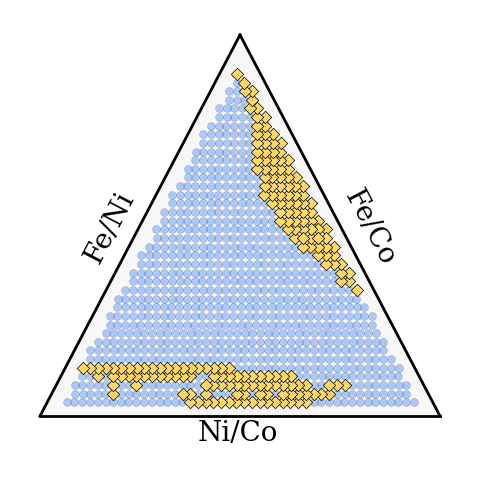

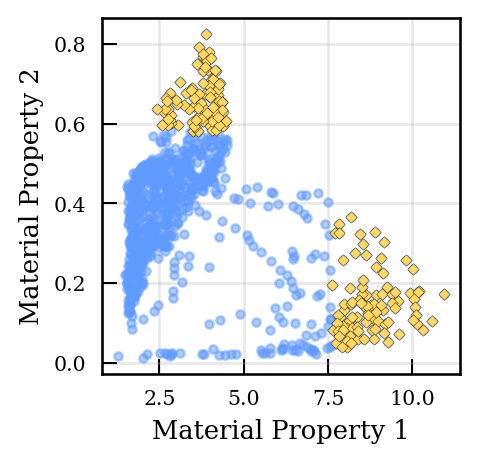

In [12]:
plot_algo_true_function(algorithm, x_scaler, y_scaler, X, Y, posterior_mean=None, posterior_samples=None)

## Running an algorithm on the posterior mean or posterior samples from a Gaussian Process

The catch in the analysis above is that of course we do not actually know Y. We only know X! Y is expensive and time-consuming to obtain. The question is, can we perform experiments (i.e. choose and x and measure y) in an intelligent way to approximate the result of running the algorithm on the true function without having to do the full set of experiments. 

The answer is yes, using the technique of Bayesian Algorithm Execution. Here, the idea is to train a Gaussian Process model to approximate Y using small datasets. Here the intuition is that the algorithm can be executed on the predicted Y rather than on the true Y. We can use the information from the algorithm output to guide decision making.

Let's see how to do this. First we start with a small dataset consisting of a small subset of X and Y:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.975, random_state=42)
X_train.shape, y_train.shape

((23, 2), (23, 2))

We define a Gaussian Process model and fit it to the data. Note, we use a custom class MGPR which is a simple wrapper on the sklearn GaussianProcessRegressor in order to have multiple independent GPs (one for each measured property). 

In [14]:
kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
kernel_initial_list = n_properties * [kernel_initial]

multi_gpr = MGPR(kernel_list=kernel_initial_list)

multi_gpr.fit(X_train, y_train)

Now that we have fitted the GP model, we can use it to predict a mean response (posterior_mean) and a predicted uncertainty (posterior_std) across the entire design space. 

In [15]:
posterior_mean, posterior_std = multi_gpr.predict(X)


Now, finally, we can execute our algorithm on the posterior_mean instead of Y. This will give us a set of points predicted (based on the posterior mean) to be the target design points. These points are shown in maroon below. Note, even with relatively limited data, there is substantial overlap between the predicted and true target points. Executing an algorithm on the posterior mean is a core idea of the MeanBAX algorithm (tutorial 2). 

predicted X:  [[91.7  3.6]
 [89.7  3.6]
 [87.8  3.6]
 [85.9  3.6]
 [84.   3.6]
 [82.   3.6]
 [80.1  3.6]
 [78.2  3.6]
 [76.2  3.6]
 [56.8 33.1]
 [59.6 35.4]
 [57.6 35.4]
 [55.7 35.4]
 [53.8 35.4]
 [51.9 35.4]
 [49.9 35.4]
 [44.  51.2]
 [42.1 51.2]
 [40.1 51.2]
 [58.4 37.6]
 [56.5 37.6]
 [54.6 37.6]
 [52.7 37.6]
 [50.7 37.6]
 [48.8 37.6]
 [46.9 37.6]
 [55.4 39.9]
 [53.5 39.9]
 [51.5 39.9]
 [49.6 39.9]
 [47.7 39.9]
 [45.8 39.9]
 [52.3 42.2]
 [50.4 42.2]
 [48.5 42.2]
 [46.6 42.2]
 [44.6 42.2]
 [84.4 10.4]
 [82.5 10.4]
 [80.6 10.4]
 [78.7 10.4]
 [76.7 10.4]
 [74.8 10.4]
 [72.9 10.4]
 [71.  10.4]
 [69.  10.4]
 [67.1 10.4]
 [65.2 10.4]
 [63.2 10.4]
 [61.3 10.4]
 [59.4 10.4]
 [57.5 10.4]
 [55.5 10.4]
 [53.6 10.4]
 [51.7 10.4]
 [49.7 10.4]
 [47.8 10.4]
 [45.9 10.4]
 [44.  10.4]
 [42.  10.4]
 [40.1 10.4]
 [38.2 10.4]
 [36.3 10.4]
 [34.3 10.4]
 [32.4 10.4]
 [30.5 10.4]
 [28.5 10.4]
 [26.6 10.4]
 [24.7 10.4]
 [22.8 10.4]
 [20.8 10.4]
 [18.9 10.4]
 [17.  10.4]
 [15.  10.4]
 [13.1 10.4]
 [11.2 10.4

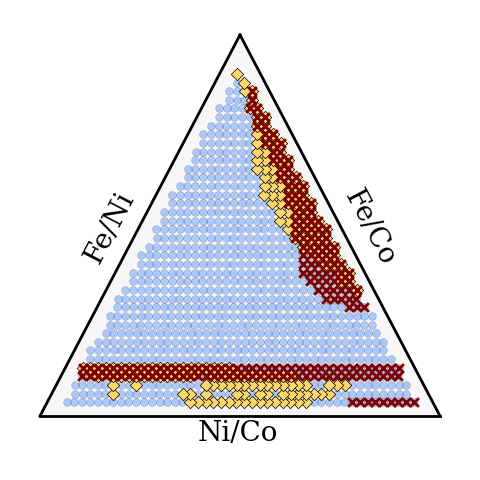

In [17]:
algorithm = PercentileIntersection2D(user_algo_params=user_algo_params)
posterior_mean_subset_ids = algorithm.identify_subspace(f_x = posterior_mean, x = X)
print("predicted X: ", X_unnorm[posterior_mean_subset_ids])
plot_algo_true_function(algorithm, x_scaler, y_scaler, X, Y, posterior_mean=posterior_mean, posterior_samples=None)

In addition to the posterior mean, we can also draw posterior samples from the GP model. Each posterior sample represents a guess over the entire domain of the values of the properties. Again, we can run our algorithm on posterior samples to get predicted target locations. In the example below, we draw 20 functions from the posterior distribution of the GP and execute our algorithm.

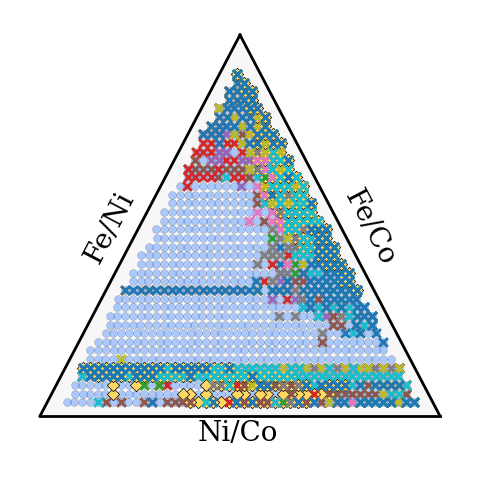

In [18]:
posterior_samples = multi_gpr.sample_y(X, n_samples = 20)
plot_algo_true_function(algorithm, x_scaler, y_scaler, X, Y, posterior_mean=None, posterior_samples=posterior_samples)

Executing an algorithm on the posterior samples is a core idea of the InfoBAx algorithm (tutorial 2). In tutorial 2, we will see how the information of algorithm execution on ML fitting models is converted in an acquisition function for efficient sampling. 
